In [9]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

# for EDA
import cv2
import matplotlib.pyplot as plt
import PIL
import torchvision.transforms as transforms
from PIL import ImageFont, ImageDraw, Image

In [3]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='../dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/faster_rcnn_r50_fpn_1x_trash'

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [4]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/detection/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


In [6]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                ] 5/4871, 6.1 task/s, elapsed: 1s, ETA:   797s

/opt/ml/detection/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/ml/detection/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 28.8 task/s, elapsed: 169s, ETA:     0s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

,PredictionString,image_id
0,0 0.36599502 482.46924 585.5056 566.4883 662.1...,test/0000.jpg
1,0 0.4790823 632.8151 632.69275 890.5195 969.34...,test/0001.jpg
2,0 0.6379567 870.2293 255.40341 912.92584 322.6...,test/0002.jpg
3,0 0.22092833 152.26062 259.7317 904.8231 819.6...,test/0003.jpg
4,0 0.56575626 462.09412 408.61627 660.985 544.7...,test/0004.jpg


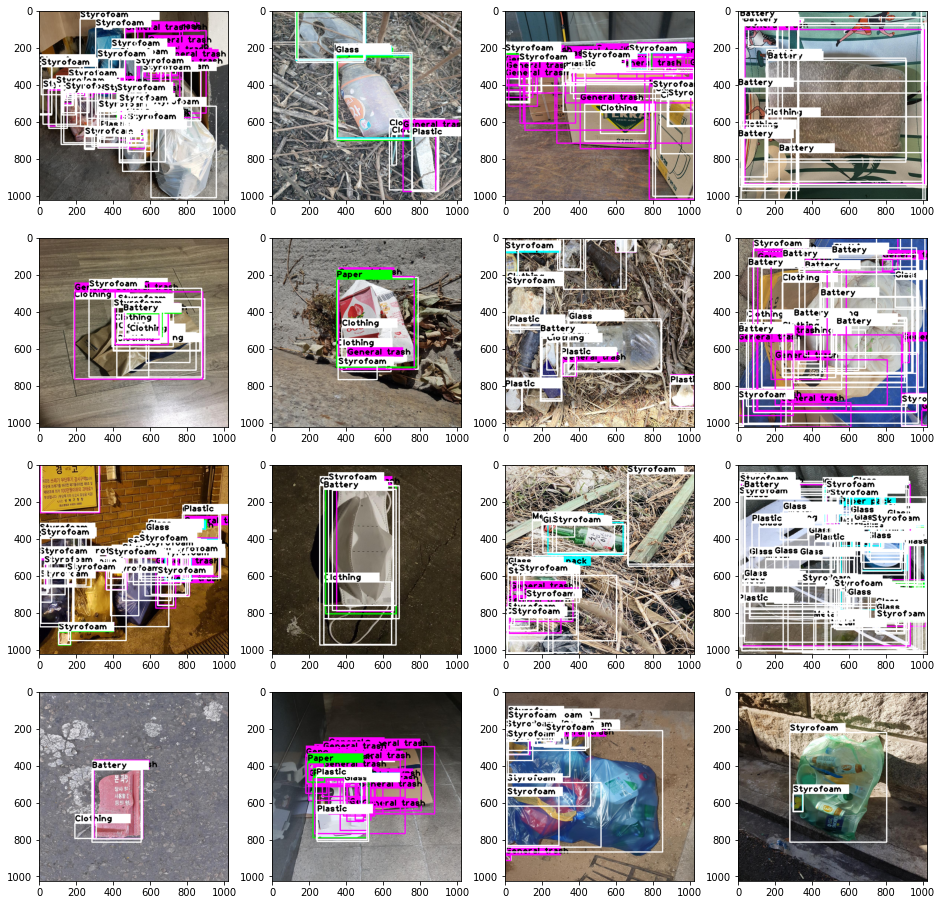

In [11]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [(250,0,50), (0, 255, 0), (0, 180, 80), (185, 185, 185), (100, 100, 100), (200, 50, 150), (50, 150, 200), (50, 200, 150), (200, 200, 200), (255,255,255)]


class_num = 10
plt.figure(figsize=(16,16))
for i, out in enumerate(output):
    if i < 16:
        prediction_string = ''
        image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]

        image = cv2.imread(os.path.join('../dataset', image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        for j in range(class_num):
            for o in out[j]:
                prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                    o[2]) + ' ' + str(o[3]) + ' '

                label_idx = j - 1
                cv2.rectangle(image, (int(o[0]), int(o[1])), (int(o[2]), int(o[3])), class_color_list[label_idx], 5)

                text = class_name_list[label_idx]    
                cv2.rectangle(image, (int(o[0]), int(o[1] - 50)), (int(o[0]) + 300, int(o[1])), class_color_list[label_idx], -1)
                cv2.putText(image, text, (int(o[0]), int(o[1] - 10)), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 5, cv2.LINE_AA)
                
        plt.subplot(4, 4, i+1)
        plt.imshow(image)

        prediction_strings.append(prediction_string)
        file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()